# Time Series Forecasting

In [1]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary

## Components of a time series:
1. Level
2. Trend
3. Seasonaility
4. Noise

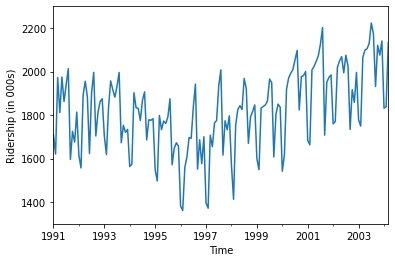

In [3]:
amtrak_df = pd.read_csv('datasets\\Amtrak.csv')

# convert the date information to a datetime object
amtrak_df['Date'] = pd.to_datetime(amtrak_df.Month, format='%d/%m/%Y')

# convert dataframe column to series (name is used to label the data)
ridership_ts = pd.Series(amtrak_df.Ridership.values, index=amtrak_df.Date, name='Ridership')

# define the time series frequency
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# plot the series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
plt.show()

### Amtrak Ridership (monthly)

Assessment

    Level - about 1,800,000 passengers per month
    Trend - Appears to be U-shaped

More detailed Assessment

    Zoom in or out:  Different patterns are discernible at different time period scales
    Change y-scale:  For example, change to logarithmic (ax.set_yscale(‘log’)) to check for exponential trend
    Add trend line:  Helps decide which trend (e.g. linear, exponential, quadratic) is best approximation
    Suppress seasonality:  Helps reveal more fundamental trends


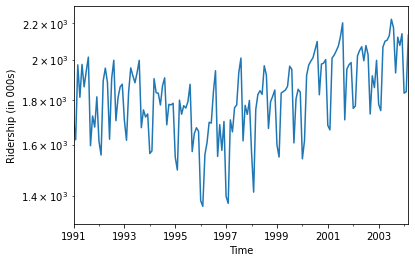

In [4]:
# change y-scale

# plot the series
ax = ridership_ts.plot()
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
plt.show()

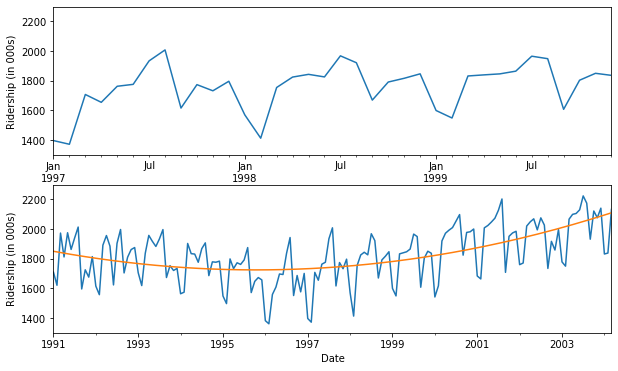

In [5]:
# create short time series from 1997 to 1999 using a slice 
ridership_ts_3yrs = ridership_ts['1997':'1999']

# create a data frame with additional independent variables from time series
# the following command adds a constant term, a trend term and a quadratic trend term
ridership_df = tsatools.add_trend(ridership_ts, trend='ctt')
# fit a linear regression model to the time series
ridership_lm = sm.ols(formula='Ridership ~ trend + trend_squared', data=ridership_df).fit()

# shorter and longer time series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
ridership_ts_3yrs.plot(ax=axes[0])
ridership_ts.plot(ax=axes[1])
for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    ax.set_ylim(1300, 2300)
ridership_lm.predict(ridership_df).plot(ax=axes[1])
plt.show()

## Note that seasonality* (summer peaks) is revealed when you zoom in.

Don’t confuse the time series term “season,” which is the period over which a cyclical pattern repeats (e.g. a year), with the standard English seasons of the year (fall, winter, etc.).

## Partitioning

1. Divide data into training portion and validation portion
2. Test model on the validation portion
3. Performance can be assessed against the “naïve benchmark” – naïve forecast is simply the most recent value in the time series 
    
## Partitioning is not random

1. Random partitioning would leave holes in the data, which causes problems
2. Forecasting methods assume regular sequential data
3. Instead of random selection, divide data into two parts 
    - Train on early data
    - Validate on later data

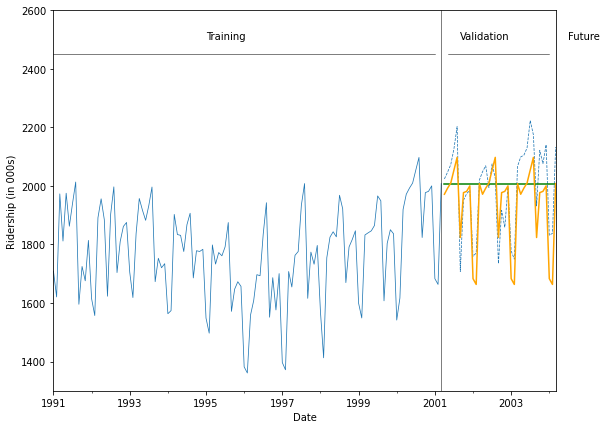

In [6]:
nValid = 36  # last 36 values is the validation data
nTrain = len(ridership_ts) - nValid

# partition the data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# Generate the naive and seasonal naive forecast
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)

# plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
ax.set_xlim('1990', '2006-6')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')

# Determine coordinates for drawing the arrows and lines
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, '2006')
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])

ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validation')
ax.text('2004-7', 2500, 'Future')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)
plt.show()

### Regression Statistics

In [7]:
regressionSummary(valid_ts, naive_pred)


Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214


In [8]:
regressionSummary(valid_ts, seasonal_pred)


Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


In [9]:
print('naive model in training set')
regressionSummary(train_ts[1:], train_ts[:-1])

print('seasonal model in training set')
regressionSummary(train_ts[12:], train_ts[:-12])

naive model in training set

Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714
seasonal model in training set

Regression statistics

                      Mean Error (ME) : 13.9399
       Root Mean Squared Error (RMSE) : 99.2656
            Mean Absolute Error (MAE) : 82.4920
          Mean Percentage Error (MPE) : 0.5851
Mean Absolute Percentage Error (MAPE) : 4.7153


<AxesSubplot:xlabel='Date'>

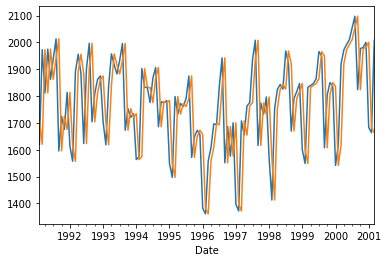

In [10]:
naive_train_ts = pd.Series(train_ts[:-1].values, index=train_ts[1:].index)
ax = train_ts[1:].plot()
naive_train_ts.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

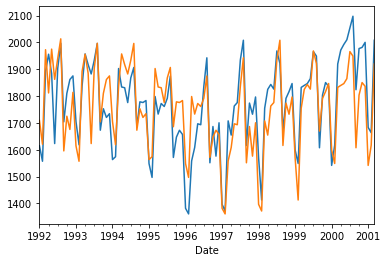

In [11]:
seasonal_train_ts = pd.Series(train_ts[:-12].values, index=train_ts[12:].index)
ax = train_ts[12:].plot()
seasonal_train_ts.plot(ax=ax)

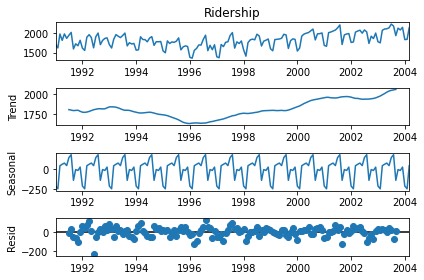

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ridership_ts, model='additive')
result.plot()
plt.show()